___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___

<h1 style="text-align: center;">Deep Learning<br><br>Session - 10 Part -1<br><br>Univariate Time Series Forecasting with RNN<br><br>RSCCASN<br><h1>

# Data Info

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

# Recognizing and Understanding Data¶

In [3]:
df = pd.read_csv('RSCCASN.csv',
                index_col='DATE',
                parse_dates=True
                )

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

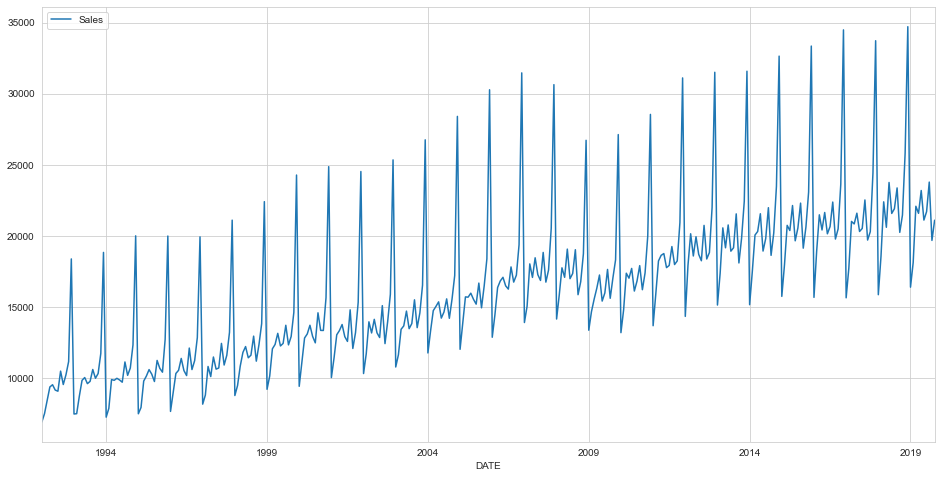

In [7]:
df.plot(figsize=(16,8))

# Preprocessing of Data

## Train Test Split

In [8]:
len(df)

334

In [9]:
test_size = 24
# datamdaki saykıl 12 olduğu için bu rakamdan büyük bir test size belirledim.

In [10]:
test_ind = len(df)- test_size
test_ind

310

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [80]:
train.iloc[309:]

,Sales
DATE,
2017-10-01,20307


In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-06-01,20322
2017-07-01,20535
2017-08-01,22536


In [13]:
test

,Sales
DATE,
2017-11-01,24438
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585
2018-03-01,22404
2018-04-01,20616
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919


## Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [19]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

# generator her defasında 12 lik uzunlukta veri setini alıp 13. veriyi üretiyor.
# dolayısıyla datanın son 12 lik verisinde duruyor. çünkü sonraki adımda elinde 12 veri kalmadığı için.
# bu yüzden datanın uzunluğu -12 (lenght değeri) adet veri üretebiliyor.

In [20]:
len(generator)

298

In [21]:
generator[0]

# generator modelimin aradığı veri düzenin oluşturdu bana.
# ürettiği ilk eleman ise bu aşağıdaki. 
# bu 12 değerden 13.yü tahmin edecek..

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


# Modelling

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
train_scaled.shape

(310, 1)

In [26]:
n_features = train_scaled.shape[1]

In [27]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))  # 2 değeri karşılaştıracağım için çıkış layer ında 1 nöron olmalı.
model.compile(optimizer = 'adam', loss = 'mse')

# LSTM den sonra tekrar LSTM kullanilacaksa return_squence=True yaziyoruz. Ayni sey GRU icin de gecerli

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
# params = 4 * ((size_of_input + 1) * size_of_output + size_of_output^2)
4 * ((1+1)*100+(100**2))

40800

In [30]:
4 * ((100+1)*50+(50**2))

30200

## EarlyStopping and Validation Generator

In [81]:
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
early_stop = EarlyStopping(monitor = 'val_loss', mode='min', patience = 10, restore_best_weights = True)
# monitor de belirdegimiz takip edilecek score a göre mode secilmeli. 
# Hata score u icin min olarak, recall vb score lar icin max olarak secilmeli.

In [93]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [94]:
len(validation_generator)

# 24-12 = 12 tane 

# son 24 taneyi test için ayırdık, bunların içinden stride 1 olacak şekilde 
# 12 lik gruplar halinde ve kaydıra kaydıra işlem yaparak 12 tane değer üretti. 

12

In [95]:
model.fit(x = generator,
          epochs = 120,
          validation_data = validation_generator,
          callbacks = [early_stop])

Epoch 1/120
322/322 [==============================] - 4s 11ms/step - loss: 0.0065 - val_loss: 0.0025
Epoch 2/120
322/322 [==============================] - 4s 11ms/step - loss: 0.0026 - val_loss: 8.9804e-04
Epoch 3/120
322/322 [==============================] - 4s 11ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 4/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 6/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/120
322/322 [==============================] - 3s 9ms/step - loss: 0.0018 - val_loss: 0.0080
Epoch 8/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/120
322/322 [==============================] - 3s 8ms/step - loss: 0.0026 -

<AxesSubplot:>

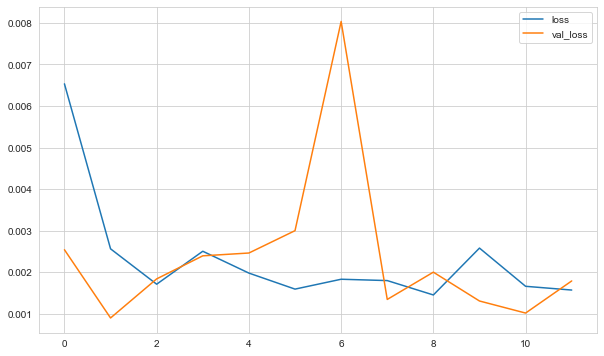

In [96]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

# Evaluation on Test Data

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [98]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [99]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)
    
# train datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. bundan ileriye forecast yapacağız
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp test_prediction a kaydettim. 

1/1 [==============================] - 0s 27ms/step


In [100]:
predictions_scaled

[array([0.6617446], dtype=float32),
 array([1.0496691], dtype=float32),
 array([0.31977302], dtype=float32),
 array([0.4055773], dtype=float32),
 array([0.5163423], dtype=float32),
 array([0.51433057], dtype=float32),
 array([0.52520096], dtype=float32),
 array([0.4673838], dtype=float32),
 array([0.46973372], dtype=float32),
 array([0.50185025], dtype=float32),
 array([0.40078467], dtype=float32),
 array([0.4355982], dtype=float32)]

In [101]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.8090150432857155 
mae: 0.05694018981817767 
mse: 0.004229825089723403 
rmse: 0.06503710548389591


## Inverse Transformation and Comparing

In [102]:
predictions = scaler.inverse_transform(predictions_scaled)

In [103]:
compare = test[:12]

In [104]:
compare['Predictions'] = predictions

In [105]:
compare

,Sales,Predictions
DATE,,
2017-11-01,24438,25165.093
2017-12-01,33720,35850.087
2018-01-01,15881,15745.828
2018-02-01,18585,18109.221
2018-03-01,22404,21160.132
2018-04-01,20616,21104.721
2018-05-01,23764,21404.135
2018-06-01,21589,19811.619
2018-07-01,21919,19876.345


<AxesSubplot:xlabel='DATE'>

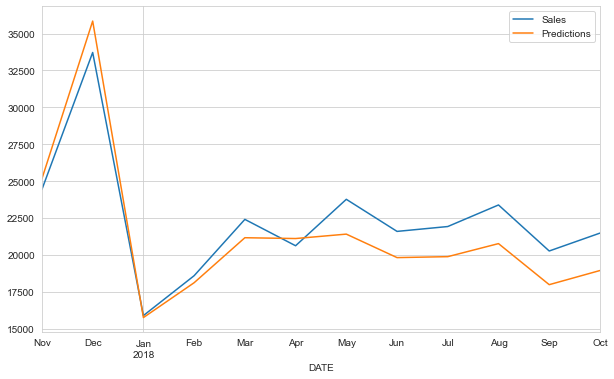

In [106]:
compare.plot()

In [107]:
eval_metrics(compare.Sales, compare.Predictions)

r2_score: 0.8090150432857149 
mae: 1568.3605883518874 
mse: 3209049.589761836 
rmse: 1791.3820334484312


# Retrain and Forecasting

In [108]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [109]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [110]:
len(df)

334

In [111]:
len(generator)

322

In [112]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit(x = generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 8s 11ms/step - loss: 0.0214
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0193
Epoch 3/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0195
Epoch 4/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0169
Epoch 5/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0169
Epoch 6/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0157
Epoch 7/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0144
Epoch 8/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0121
Epoch 9/15
322/322 [==============================] - 3s 8ms/step - loss: 0.0108
Epoch 10/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0102
Epoch 11/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0082
Epoch 12/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0063
Epoch 13/15
322/322 [==

In [124]:
scaled_full_data.shape

(334, 1)

In [125]:
scaled_full_data[-length:].shape

(12, 1)

In [147]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
# tüm datamın son 12 ye 1 lik kısmını aldım. artık bunu ileriye doğru predict te (forecast) kullanıcam
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)
    
    # Burada tüm datamızın sonundan 12lik bir parçayı aldık. bu bizim ilk eval_batch imiz olacak. 
# sonra bunu reshape yaptık (1,12,1) oldu  ( (1, length, n_features) )
# bundan for döngüsü içinde current_batch i hep bir ilerletecek şekilde predict ler alıp alıp forecast e kaydettim. 

1/1 [==============================] - 0s 30ms/step


In [148]:
forecast = scaler.inverse_transform(forecast)

In [149]:
forecast

array([[30121.67199993],
       [36410.32114029],
       [21315.91751289],
       [26246.20541   ],
       [29341.87014198],
       [28246.81938457],
       [29232.31942558],
       [26759.95177555],
       [27123.34007835],
       [27557.64214516],
       [24254.10555267],
       [25972.92293262],
       [30246.81277752],
       [36540.36418438],
       [19991.96325231],
       [22967.05866051],
       [26580.49532986],
       [26226.99364758],
       [26454.56322861],
       [24636.42980385],
       [24990.93623734],
       [26015.96305943],
       [23634.15107441],
       [25504.2951498 ],
       [29922.35694218],
       [35410.60354137],
       [20406.2991724 ],
       [24026.36194611],
       [27548.50416279],
       [25760.91386127],
       [28145.33622932],
       [25278.72522068],
       [25110.02552319],
       [25049.83567238],
       [22355.40487194],
       [23884.62635612],
       [27367.78685284],
       [32370.38728523],
       [20115.44750381],
       [22524.70709181],


In [150]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [151]:
forecast_index = pd.date_range(start = '2019-11-01', periods = length, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [152]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [153]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
# forecast lerden dataframe oluşturduk

In [154]:
forecast_df

,Forecast
2019-11-01,30121.672
2019-12-01,36410.321
2020-01-01,21315.918
2020-02-01,26246.205
2020-03-01,29341.870
2020-04-01,28246.819
2020-05-01,29232.319
2020-06-01,26759.952
2020-07-01,27123.340
2020-08-01,27557.642


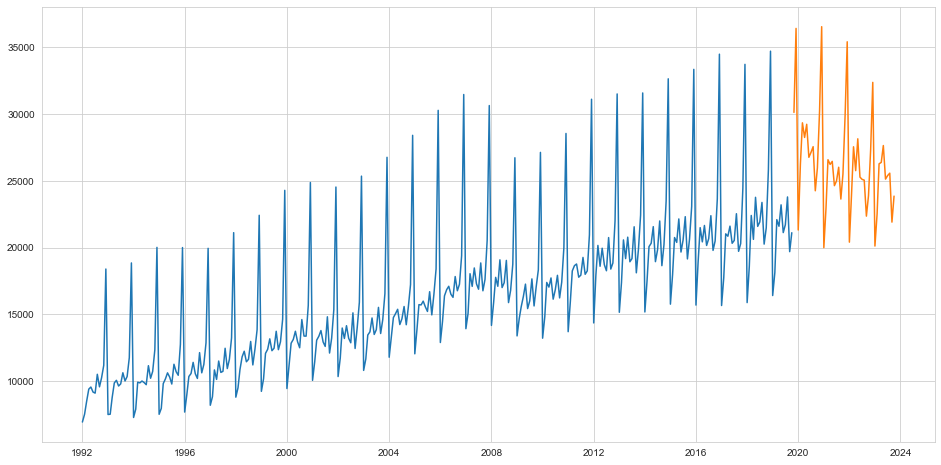

In [155]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

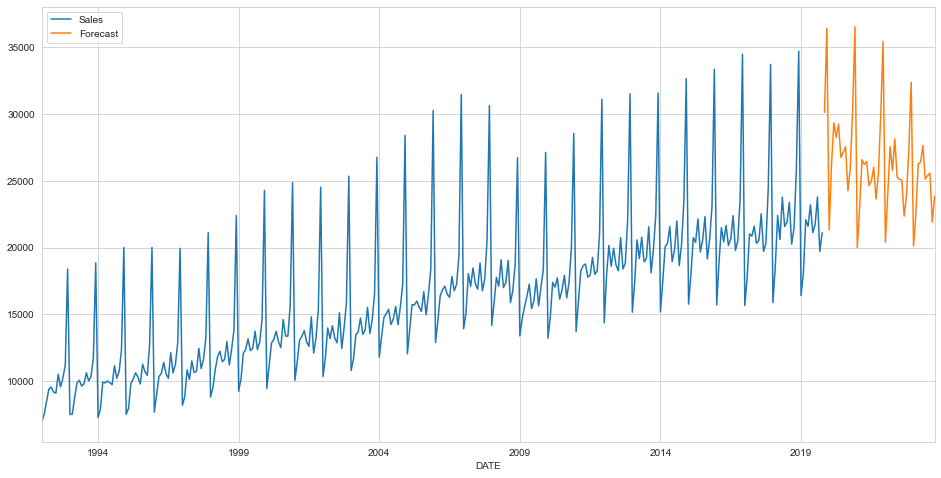

In [156]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

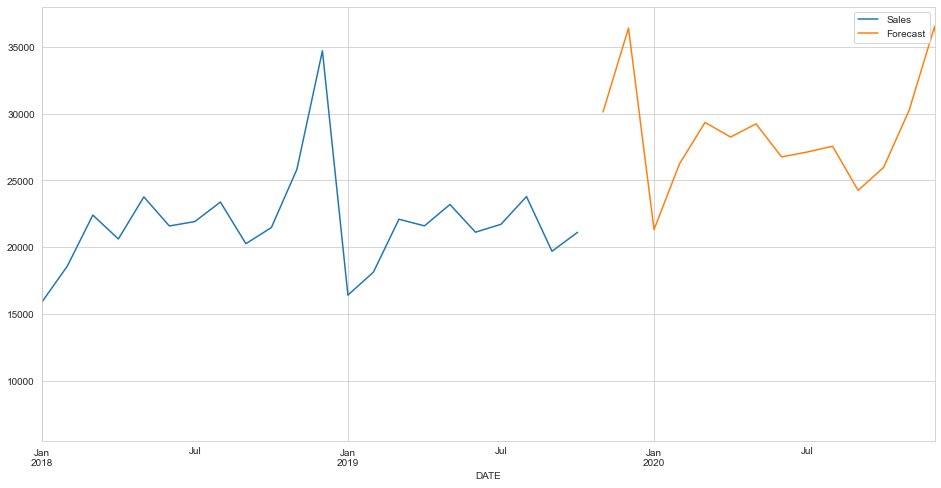

In [157]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')

In [158]:
dataset_total = pd.concat((df['Sales'], forecast_df['Forecast']), axis=0)

<AxesSubplot:>

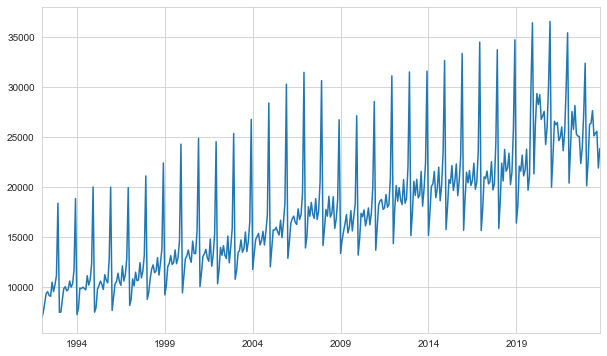

In [159]:
dataset_total.plot()

___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___